# Reducing the number of high fatality accidents

## 📖 Background
You work for the road safety team within the department of transport and are looking into how they can reduce the number of major incidents. The safety team classes major incidents as fatal accidents involving 3+ casualties. They are trying to learn more about the characteristics of these major incidents so they can brainstorm interventions that could lower the number of deaths. They have asked for your assistance with answering a number of questions.

## 💾 The data
The reporting department have been collecting data on every accident that is reported. They've included this along with a lookup file for 2020's accidents.

*Published by the department for transport. https://data.gov.uk/dataset/road-accidents-safety-data* 
*Contains public sector information licensed under the Open Government Licence v3.0.*

## 💪 Competition challenge

Create a report that covers the following:

1. What time of day and day of the week do most major incidents happen?
2. Are there any patterns in the time of day/ day of the week when major incidents occur?
3. What characteristics stand out in major incidents compared with other accidents?
4. On what areas would you recommend the planning team focus their brainstorming efforts to reduce major incidents?

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations
sns.set_style('darkgrid')

# Utilities
import matplotlib.dates as md

# Geography 
import geopandas as gpd

# Algorithms
from sklearn.cluster import KMeans as KNN


In [2]:
df_info_book = pd.read_csv(r'./data/road-safety-lookups.csv')
df_info_book

,table,field name,code/format,label,note
0,Accident,accident_index,NaN,NaN,unique value for each accident. The accident_i...
1,Accident,accident_year,NaN,NaN,NaN
2,Accident,accident_reference,NaN,NaN,In year id used by the police to reference a c...
3,Accident,longitude,NaN,NaN,Null if not known
4,Accident,Latitude,NaN,NaN,Null if not known
...,...,...,...,...,...
124,Accident,carriageway_hazards,9,unknown (self reported),NaN
125,Accident,urban_or_rural_area,1,Urban,field introduced in 1994
126,Accident,urban_or_rural_area,2,Rural,field introduced in 1994
127,Accident,urban_or_rural_area,3,Unallocated,field introduced in 1994


In [3]:
df_accidents = pd.read_csv(r'./data/accident-data.csv', parse_dates=[['date', 'time']])
df_accidents.head()

,date_time,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,...,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
0,2020-04-02 09:00:00,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,3,...,6,0,9,9,1,9,9,0,0,1
1,2020-04-27 13:55:00,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,2,...,6,0,0,4,1,1,1,0,0,1
2,2020-01-01 01:25:00,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,4,...,6,0,0,0,4,1,2,0,0,1
3,2020-01-01 01:50:00,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,4,...,6,0,0,4,4,1,1,0,0,1
4,2020-01-01 02:25:00,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,4,...,5,0,0,0,4,1,1,0,0,1


In [4]:
# Replace -1 with null
df_accidents = df_accidents.replace(-1, np.nan)

# Replace unknown data, marked with 99 or 9, with null
df_accidents['speed_limit'] = df_accidents['speed_limit'].replace(99, np.nan)
df_accidents['junction_detail'] = df_accidents['junction_detail'].replace(99, np.nan)
 
df_accidents['road_type'] = df_accidents['road_type'].replace(9, np.nan)
df_accidents['pedestrian_crossing_human_control'] = df_accidents['pedestrian_crossing_human_control'].replace(9, np.nan)
df_accidents['pedestrian_crossing_physical_facilities'] = df_accidents['pedestrian_crossing_physical_facilities'].replace(9, np.nan)
df_accidents['weather_conditions'] = df_accidents['weather_conditions'].replace(9, np.nan)
df_accidents['road_surface_conditions'] = df_accidents['road_surface_conditions'].replace(9, np.nan)
df_accidents['special_conditions_at_site'] = df_accidents['special_conditions_at_site'].replace(9, np.nan)
df_accidents['carriageway_hazards'] = df_accidents['carriageway_hazards'].replace(9, np.nan)

# Verifying Datatypes and missing values

In [5]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_time                                91199 non-null  datetime64[ns]
 1   accident_index                           91199 non-null  object        
 2   accident_year                            91199 non-null  int64         
 3   accident_reference                       91199 non-null  object        
 4   longitude                                91185 non-null  float64       
 5   latitude                                 91185 non-null  float64       
 6   accident_severity                        91199 non-null  int64         
 7   number_of_vehicles                       91199 non-null  int64         
 8   number_of_casualties                     91199 non-null  int64         
 9   day_of_week                            

In [6]:
# Change 'date' type (object) to datetime64[ns]
# change 'time' type (object) to timedelta
#df_accidents['date'] = df_accidents['date'].astype('datetime64[ns]')
#df_accidents['time'] = df_accidents['time'].astype('datetime64[ns]')
#df_accidents['time'] = pd.to_timedelta( df_accidents['time'] + ':00' )

In [7]:
df_accidents.drop(columns = ['junction_control','pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities'],inplace=True)
#df_accidents.dropna(inplace = True)

In [8]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date_time                   91199 non-null  datetime64[ns]
 1   accident_index              91199 non-null  object        
 2   accident_year               91199 non-null  int64         
 3   accident_reference          91199 non-null  object        
 4   longitude                   91185 non-null  float64       
 5   latitude                    91185 non-null  float64       
 6   accident_severity           91199 non-null  int64         
 7   number_of_vehicles          91199 non-null  int64         
 8   number_of_casualties        91199 non-null  int64         
 9   day_of_week                 91199 non-null  int64         
 10  first_road_class            91199 non-null  int64         
 11  first_road_number           91199 non-null  int64     

In [9]:
# df_accidents['accident_reference'].astype(int)
df_accidents[ df_accidents['accident_reference'].isin(['01T246170']) ]

,date_time,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,...,speed_limit,junction_detail,second_road_class,second_road_number,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
20905,2020-04-24 17:45:00,202001T246170,2020,01T246170,-0.07885,51.520359,3,2,2,6,...,20.0,6.0,5,0.0,1.0,NaN,NaN,NaN,NaN,1


# Thoughts

I cleared out two three columns that had more than 3% of missing data.

# Thoughts

So, there was Another thing to note, the day_of_week starts with Sunday as 0 and Saturday as 6. I'll need to change this to fit with pandas dt.dayofweek.

In [10]:
df_accidents['day_of_week'] = df_accidents['date_time'].dt.dayofweek
df_accidents['day_name'] = df_accidents['date_time'].dt.day_name()

df_accidents['month_number'] = df_accidents['date_time'].dt.month
df_accidents['month_name'] = df_accidents['date_time'].dt.month_name() 


# Next Steps

Initially, I want to analysis the day and time the accidents are occuring. From there, we can build up to what type of accidents are occuring on those dates. 

In [11]:
df_accidents_timestamp = df_accidents[ ['accident_year','date_time','day_name','month_name','month_number','day_of_week'] ].copy(deep=True)

df_accidents_timestamp


,accident_year,date_time,day_name,month_name,month_number,day_of_week
0,2020,2020-04-02 09:00:00,Thursday,April,4,3
1,2020,2020-04-27 13:55:00,Monday,April,4,0
2,2020,2020-01-01 01:25:00,Wednesday,January,1,2
3,2020,2020-01-01 01:50:00,Wednesday,January,1,2
4,2020,2020-01-01 02:25:00,Wednesday,January,1,2
...,...,...,...,...,...,...
91194,2020,2020-12-08 14:30:00,Tuesday,December,12,1
91195,2020,2020-11-13 15:05:00,Friday,November,11,4
91196,2020,2020-04-15 12:42:00,Wednesday,April,4,2
91197,2020,2020-12-15 14:00:00,Tuesday,December,12,1


In [12]:
df_accidents_timestamp['accident_year'].unique()

array([2020], dtype=int64)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

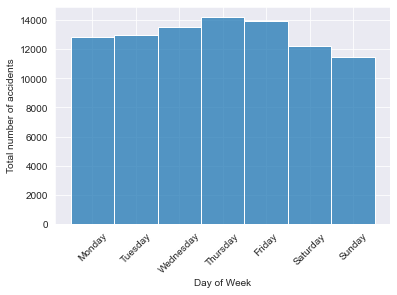

In [13]:
# Create histogram for day of week

sns.histplot(x = 'day_name', data = df_accidents_timestamp.sort_values(by='day_of_week'))

plt.ylabel('Total number of accidents')
plt.xlabel('Day of Week')

plt.xticks( rotation = 45 )


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

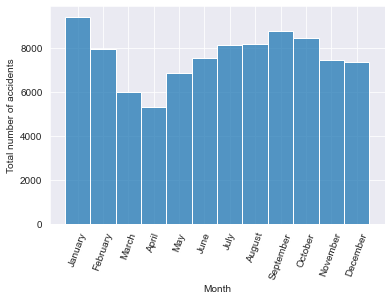

In [14]:
# Create histogram for day of week
sns.histplot(x = 'month_name', data = df_accidents_timestamp.sort_values(by='month_number') )

plt.ylabel('Total number of accidents')
plt.xlabel('Month')

plt.xticks( rotation = 70 )


# Thoughts

From the graphs above, we can see that majority of the accidents in the year 2020 occured on Thursday, followed by Friday and Wednesday. The level of severity could range from 0 to 3, which I'll look into later. In addition, a large quantity of accidents occured on January 2020, followed by September 2020 and October 2020. Interestingly, the number of accidents decreased from January 2020 to April 2020. This could be the cause of travel restrictions due to Covid-19.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

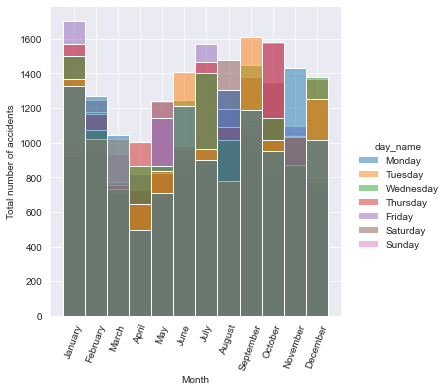

In [15]:
day_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

sns.displot(x = 'month_name', 
            data = df_accidents_timestamp.sort_values(by='month_number'),
            kind = 'hist',
            hue ='day_name' , 
            hue_order= day_list,
             )

plt.ylabel('Total number of accidents')
plt.xlabel('Month')

plt.xticks( rotation = 70 )

# Thoughts
A histogram is not a good way to see the differences in total number of accidents in the days per month. I'll try a line graph.

In [16]:
df_temp = df_accidents_timestamp[ ['day_name','month_name','month_number','day_of_week'] ].value_counts().reset_index().sort_values(by=['day_of_week','month_number'])
df_temp = df_temp.rename(columns = {0:'count'})

df_temp

,day_name,month_name,month_number,day_of_week,count
18,Monday,January,1,0,1329
21,Monday,February,2,0,1268
40,Monday,March,3,0,1042
83,Monday,April,4,0,498
81,Monday,May,5,0,711
...,...,...,...,...,...
20,Sunday,August,8,6,1303
55,Sunday,September,9,6,952
69,Sunday,October,10,6,815
39,Sunday,November,11,6,1047


In [17]:
# cumSum: Cumulative Sum of accidents for each Month per Day
df_temp['cumSum'] = df_temp[['day_of_week','count']].groupby(['day_of_week']).cumsum()

df_temp.head(13)

,day_name,month_name,month_number,day_of_week,count,cumSum
18,Monday,January,1,0,1329,1329
21,Monday,February,2,0,1268,2597
40,Monday,March,3,0,1042,3639
83,Monday,April,4,0,498,4137
81,Monday,May,5,0,711,4848
27,Monday,June,6,0,1214,6062
62,Monday,July,7,0,901,6963
19,Monday,August,8,0,1304,8267
29,Monday,September,9,0,1188,9455
54,Monday,October,10,0,953,10408


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

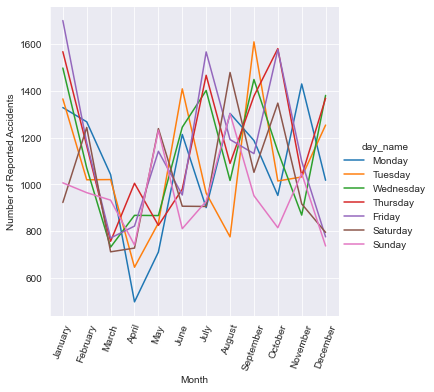

In [18]:
sns.relplot(x = 'month_name' , y = 'count', data = df_temp.sort_values(by='month_number'), kind='line' , hue = 'day_name',hue_order=day_list)

plt.xlabel('Month')
plt.ylabel('Number of Reported Accidents')

plt.xticks( rotation = 70 )


# Thoughts

The graph shows that there was a drop in accidents from January 2020 to April 2020, with no regards to the days in which the accidents happened. However, the graph is too messy to see if there's any interesting facts about the days the accidents are occuring.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

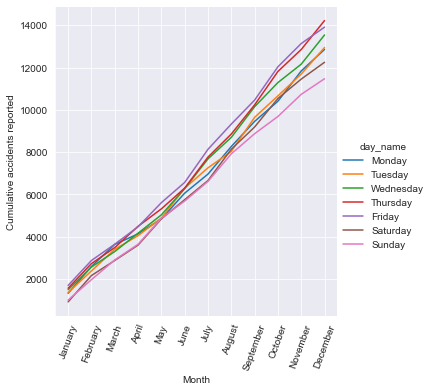

In [19]:
sns.relplot(x = 'month_name' , y = 'cumSum', data = df_temp.sort_values(by='month_number'), kind='line' , hue = 'day_name',hue_order=day_list)

plt.xlabel('Month')
plt.ylabel('Cumulative accidents reported')
plt.xticks( rotation = 70 )

# Thoughts

From the graph above, we see that majority of the accidents were occuring on a Friday from January 2020 to November 2020, followed closely by Thursday. The accumulation of accidents on each day for each month was constantly increasing. This means that the number of accidents occuring each month is about the same. 

# Next Step

I look into the time the accidents are occuring. I wonder if accidents are more frequent on a given day.

In [20]:
df_timeReport = df_accidents['date_time'].dt.strftime("%H:%M").value_counts().reset_index()
df_timeReport_V2 = df_timeReport.rename(columns={'date_time':'count','index':'time'})
df_timeReport_V2['time'] = df_timeReport_V2['time'].astype('datetime64[ns]')

df_timeReport_V2

,time,count
0,2021-12-13 17:00:00,862
1,2021-12-13 16:00:00,785
2,2021-12-13 15:00:00,774
3,2021-12-13 17:30:00,746
4,2021-12-13 18:00:00,739
...,...,...
1433,2021-12-13 03:36:00,1
1434,2021-12-13 04:58:00,1
1435,2021-12-13 04:39:00,1
1436,2021-12-13 04:33:00,1


Text(0, 0.5, 'Total number of accidents in 2020')

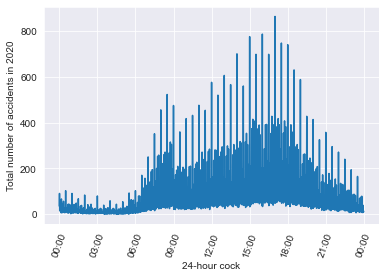

In [21]:
ax1 = sns.lineplot(x='time',y='count', data = df_timeReport_V2)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.xticks( rotation = 70 )

plt.xlabel('24-hour cock')
plt.ylabel('Total number of accidents in 2020')

# Thoughts
From the graph above, there are two peaks for the number of accidents in the day, between 8:00 - 9:00 and 15:00 - 18:00. There appears to be columns in the graph, and can be explained by the rounding of time to the 30min mark. We can do the same thing to the other times to get a better picture of when accidents are occuring within a 30min interval.

In [22]:
df_time_reported_15min = df_accidents['date_time'].dt.round('15T').dt.strftime("%H:%M").value_counts().reset_index()

df_time_reported_15min_V2 = df_time_reported_15min.rename(columns={'date_time':'count','index':'time'})
df_time_reported_15min_V2['time'] = df_time_reported_15min_V2['time'].astype('datetime64[ns]')

df_time_reported_15min_V2


,time,count
0,2021-12-13 17:00:00,2070
1,2021-12-13 17:30:00,1995
2,2021-12-13 17:15:00,1964
3,2021-12-13 15:15:00,1900
4,2021-12-13 15:30:00,1861
...,...,...
91,2021-12-13 04:15:00,129
92,2021-12-13 04:30:00,128
93,2021-12-13 03:30:00,128
94,2021-12-13 03:45:00,126


Text(0, 0.5, 'Total number of accidents in 2020')

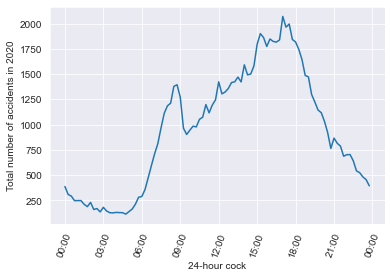

In [23]:
ax1 = sns.lineplot(x='time',y='count', data = df_time_reported_15min_V2)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.xticks( rotation = 70 )

plt.xlabel('24-hour cock')
plt.ylabel('Total number of accidents in 2020')

# Thoughts

In the graph above, the time of the accidents have been binned to a 15 min interval. Just like the previous graph, there is an increase in the number of accidents starting at 6:00 and peaks at 18:00. There is decrease in accidents between 18:00 to 00:00 and 00:00 to 6:00. 

In [24]:
#df_accidents_timestamp
df_accidents_timestamp['hour_min'] = df_accidents_timestamp['date_time'].dt.round('15T').dt.strftime("%H:%M")
df_accidents_timestamp['count'] = 0
df_accidents_timestamp_day_grouped = df_accidents_timestamp.groupby(['day_name','day_of_week','hour_min'])['count'].count().reset_index()
df_accidents_timestamp_day_grouped['hour_min'] = df_accidents_timestamp_day_grouped['hour_min'].astype('datetime64[ns]')
df_accidents_timestamp_day_grouped

,day_name,day_of_week,hour_min,count
0,Friday,4,2021-12-13 00:00:00,67
1,Friday,4,2021-12-13 00:15:00,51
2,Friday,4,2021-12-13 00:30:00,51
3,Friday,4,2021-12-13 00:45:00,28
4,Friday,4,2021-12-13 01:00:00,31
...,...,...,...,...
667,Wednesday,2,2021-12-13 22:45:00,64
668,Wednesday,2,2021-12-13 23:00:00,60
669,Wednesday,2,2021-12-13 23:15:00,74
670,Wednesday,2,2021-12-13 23:30:00,62


Text(0, 0.5, 'Total number of accidents in 2020')

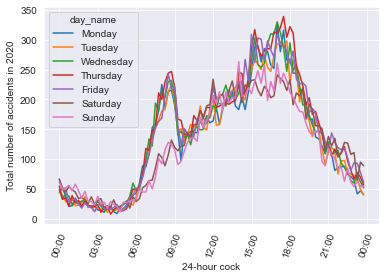

In [25]:
ax1 = sns.lineplot(x='hour_min',
                   y='count', 
                   data = df_accidents_timestamp_day_grouped,
                   hue = 'day_name',
                   hue_order=day_list)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.xticks( rotation = 70 )

plt.xlabel('24-hour cock')
plt.ylabel('Total number of accidents in 2020')

# Thoughts

In the graph above, we further show that the number of accidents begin to increase from 6:00 to 8:00 and 9:00 to 18:00 from Monday to Sunday. Interestingly, from 6:00 to 8:00 , most accidents are occuring Monday - Friday. The sharp increase in accidents from 6:00 to 8:00 can be explaied by the fact people get up to work and cause an increase in the number of cars in the road. For Saturday and Sunday, it is possible that people dont work on these days, does not getting on a vehicle and being on the road that early in the morning.

# Next Steps

So far, I explored the month, day, and time the accidents are occuring without regard on the level of severity of the event. Now that I have a general assumption of when the accidents are occuring, I'll dive deeper on the level of severity of the accidents. 

In [26]:
df_accidents_timestamp_severity = df_accidents[ ['accident_year','date_time','day_name','month_name','month_number','day_of_week','accident_severity','number_of_vehicles','number_of_casualties'] ].copy(deep=True)
df_accidents_timestamp_severity

,accident_year,date_time,day_name,month_name,month_number,day_of_week,accident_severity,number_of_vehicles,number_of_casualties
0,2020,2020-04-02 09:00:00,Thursday,April,4,3,3,1,1
1,2020,2020-04-27 13:55:00,Monday,April,4,0,3,1,2
2,2020,2020-01-01 01:25:00,Wednesday,January,1,2,3,1,1
3,2020,2020-01-01 01:50:00,Wednesday,January,1,2,2,1,1
4,2020,2020-01-01 02:25:00,Wednesday,January,1,2,3,1,2
...,...,...,...,...,...,...,...,...,...
91194,2020,2020-12-08 14:30:00,Tuesday,December,12,1,2,2,1
91195,2020,2020-11-13 15:05:00,Friday,November,11,4,3,1,1
91196,2020,2020-04-15 12:42:00,Wednesday,April,4,2,2,2,1
91197,2020,2020-12-15 14:00:00,Tuesday,December,12,1,3,2,1


In [27]:
df_accidents_timestamp_severity['major_incident'] = 0
df_accidents_timestamp_severity.loc[ df_accidents_timestamp_severity['number_of_casualties'] >= 3 ,'major_incident']  = 1



In [28]:
df_accidents_timestamp_severity[['accident_severity','number_of_vehicles','number_of_casualties','major_incident']].describe()

,accident_severity,number_of_vehicles,number_of_casualties,major_incident
count,91199.000000,91199.000000,91199.000000,91199.000000
mean,2.768232,1.835272,1.267382,0.052819
std,0.456682,0.677272,0.681473,0.223672
min,1.000000,1.000000,1.000000,0.000000
25%,3.000000,1.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000,0.000000
75%,3.000000,2.000000,1.000000,0.000000
max,3.000000,13.000000,41.000000,1.000000


In [29]:
df_accidents_timestamp_severity['major_incident'].value_counts()

0    86382
1     4817
Name: major_incident, dtype: int64

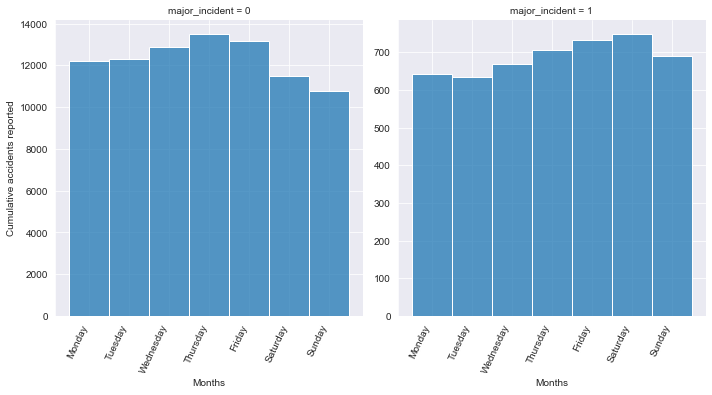

In [30]:
# sns.displot(x = 'day_name', 
#              data = df_accidents_timestamp_severity.sort_values(by='day_of_week'),
#              hue= 'major_incident',
#              kind = 'hist',
#              multiple="stack")

#plt.ylabel('Total number of accidents')
#plt.xlabel('Day of Week')

#plt.xticks( rotation = 45 )


distPlot = sns.displot(x = 'day_name', 
             data = df_accidents_timestamp_severity.sort_values(by='day_of_week'),
             col= 'major_incident',
             kind = 'hist',
             facet_kws={'sharey': False, 'sharex': False})


distPlot.set_ylabels('Cumulative accidents reported')
distPlot.set_xlabels('Months')
distPlot.set_xticklabels(rotation=65, horizontalalignment='right')


# Thoughts

From the graph above, majority of non-major accidents occured on Thursday, followed by Friday. In comparison, most major accidents occured on Friday and Saturday. 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

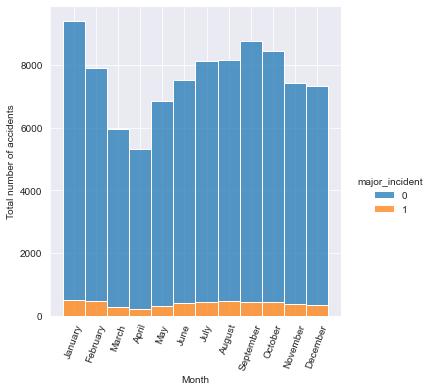

In [31]:
sns.displot(x = 'month_name', 
            data = df_accidents_timestamp_severity.sort_values(by='month_number'),
            kind = 'hist',
            hue='major_incident',
            multiple="stack")

plt.ylabel('Total number of accidents')
plt.xlabel('Month')

plt.xticks( rotation = 70 )

# Thoughts

Just like the previous graph, majority of accidents are non-major incidents.

In [32]:
df_temp_acc = df_accidents_timestamp_severity[['major_incident','day_name','month_name','day_of_week','month_number']].copy(deep=True)
df_temp_acc.groupby(['major_incident','month_name','day_name','day_of_week','month_number'])

df_temp_acc_V2 = df_temp_acc.value_counts().reset_index().sort_values(by=['major_incident','day_of_week','month_number']).rename(columns={0:'frequency'})

df_temp_acc_V2['cum_frequency'] = df_temp_acc_V2.groupby(['major_incident','day_of_week'])['frequency'].cumsum()

df_temp_acc_V2



,major_incident,day_name,month_name,day_of_week,month_number,frequency,cum_frequency
17,0,Monday,January,0,1,1266,1266
21,0,Monday,February,0,2,1201,2467
38,0,Monday,March,0,3,992,3459
83,0,Monday,April,0,4,481,3940
80,0,Monday,May,0,5,682,4622
...,...,...,...,...,...,...,...
92,1,Sunday,August,6,8,85,460
120,1,Sunday,September,6,9,59,519
141,1,Sunday,October,6,10,46,565
98,1,Sunday,November,6,11,78,643


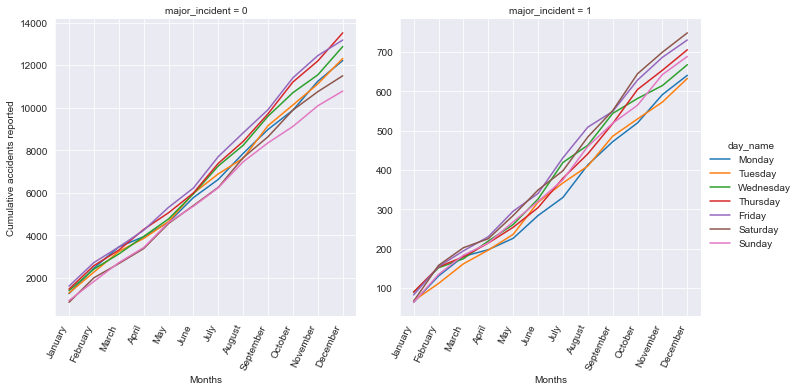

In [33]:
plots = sns.relplot(x='month_name', 
            y='cum_frequency',
            data= df_temp_acc_V2, 
            hue= 'day_name',
            kind = 'line',
            col = 'major_incident',
            facet_kws={'sharey': False, 'sharex': False})


plots.set_ylabels('Cumulative accidents reported')
plots.set_xlabels('Months')

plots.set_xticklabels(rotation=65, horizontalalignment='right')

plt.subplots_adjust(hspace = 0.3)

# Thoughts

As observed from the graphs above, throughout the 2020 year, Friday was the most frequent day of accidents for non-major accidents, followed by Thursday. Friday and Saturday were the most frequent days for major incidents. For non-major incidents , the days differ from 500 - 3000 accidents while major accident's days differ from 100 - 300 accidents. 

In [34]:
# CREATE A CUM SUM COLUMN FOR EACH MONTH FOR EACH DAY

#df_temp[['day_of_week','count']].groupby(['month_name','day_of_week']).cumsum()
# df_accidents_timestamp_severity.groupby(['month_name','major_incident'])['day_name'].count()

df_temp_acc = df_accidents_timestamp_severity[['month_name','day_name',]].copy(deep = True)
df_temp_acc['frequency'] = 0
df_temp_acc.groupby(['month_name','day_name']).count().reset_index() #.sort_values(by=['day_name','month_name'])




,month_name,day_name,frequency
0,April,Friday,822
1,April,Monday,498
2,April,Saturday,728
3,April,Sunday,741
4,April,Thursday,1005
...,...,...,...
79,September,Saturday,1052
80,September,Sunday,952
81,September,Thursday,1378
82,September,Tuesday,1610


In [35]:
df_accidents_timestamp_severity['time_hour'] = df_accidents_timestamp_severity['date_time'].dt.round('15T').dt.strftime("%H:%M")
df_accidents_timestamp_severity['frequency'] = 0
df_accidents_timestamp_severity_V2 = df_accidents_timestamp_severity.groupby(['major_incident','time_hour'])['frequency'].count().reset_index()

df_accidents_timestamp_severity_V2['time'] = df_accidents_timestamp_severity_V2['time_hour'].astype('datetime64[ns]')

df_accidents_timestamp_severity_V2


,major_incident,time_hour,frequency,time
0,0,00:00,353,2021-12-13 00:00:00
1,0,00:15,285,2021-12-13 00:15:00
2,0,00:30,265,2021-12-13 00:30:00
3,0,00:45,231,2021-12-13 00:45:00
4,0,01:00,230,2021-12-13 01:00:00
...,...,...,...,...
187,1,22:45,49,2021-12-13 22:45:00
188,1,23:00,37,2021-12-13 23:00:00
189,1,23:15,43,2021-12-13 23:15:00
190,1,23:30,27,2021-12-13 23:30:00


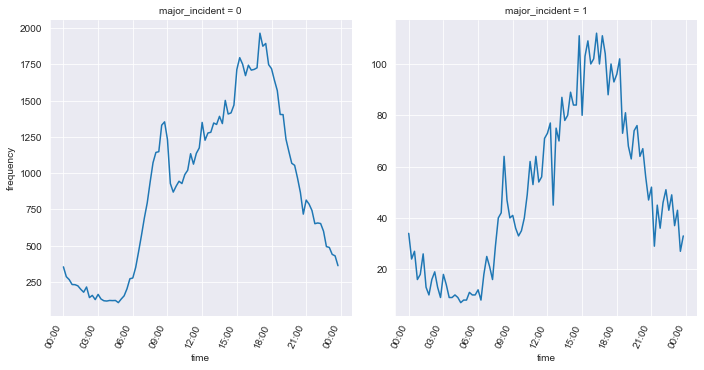

In [53]:

g = sns.relplot(x='time',
            y= 'frequency',
            data = df_accidents_timestamp_severity_V2,
            col = 'major_incident',
            kind = 'line',
            facet_kws={'sharey':False})

g.set_xticklabels(rotation=65, horizontalalignment='right')

for axs in g.axes.flatten():
    axs.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

# ax1 = sns.lineplot(x='time', 
#                    y='frequency', 
#                    data = df_accidents_timestamp_severity_V2,
#                    hue = 'major_incident')


# ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
# plt.xticks( rotation = 70 )

# plt.xlabel('24-hour cock')
# plt.ylabel('Total number of accidents in 2020')

# Thoughts

From the graph above, with both major and non-major incidents, accidents tend to increase from 6:00 to 8:00 and from 9:00 to 18:00 while decreasing from 9:00 to 10:00 and 18:00 to 8:00. The most frequent time for a major and non-major accident was at 17:30 while the less frequent time for an accident was at 05:00.

# Answering Questions

What time of day and day of the week do most major incidents happen?

- Throughout 2020, major-accidents occur on Friday and Saturday with a peak time at 8:30 and 17:30. Moreover, most major accidents occur between 8:30 to 28:00.

Are there any patterns in the time of day/ day of the week when major incidents occur?

- There is a safe assumption that the number of vehicles on the road increases from 6:00 to 8:30 as residents begin to go to work. This can explain why there is a sharp increase of accidents during that interval. Likewise, it is safe to assume that the number of vehicles on the road decreases after 17:30. That would explain why the number of  accidents decrease sharply after 17:30.

# Next Step 

With the information gathered so far, now it's a good time to start analyzing the differences between the fatality levels and the location in which the accidents are occuring.

In [37]:
# Get the boundaries of UK
df_world_countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

df_UK = df_world_countries[ df_world_countries['name'] == "United Kingdom"]

# df_UK.plot(color="lightgrey")

In [38]:
df_accidents_V2 = df_accidents.copy(deep = True)
df_accidents_V2['major_incident'] = 0
df_accidents_V2.loc[ df_accidents_V2['number_of_casualties'] >= 3 ,'major_incident']  = 1



In [39]:
urban_rural_label = df_info_book[ df_info_book['field name'] == 'urban_or_rural_area' ][['code/format','label']]
urban_rural_label['code/format'] = urban_rural_label['code/format'].astype(int)
urban_rural_labels_V2 = urban_rural_label.rename(columns={'label':'urban_or_rural_area_label'})




In [54]:
df_accidents_V3 = df_accidents_V2.merge( urban_rural_labels_V2, how ='left', left_on='urban_or_rural_area',right_on='code/format').drop(columns = 'code/format')
df_accidents_V3.head(5)

,date_time,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,day_name,month_number,month_name,major_incident,urban_or_rural_area_label
0,2020-04-02 09:00:00,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,3,...,NaN,NaN,0.0,0.0,1,Thursday,4,April,0,Urban
1,2020-04-27 13:55:00,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,0,...,1.0,1.0,0.0,0.0,1,Monday,4,April,0,Urban
2,2020-01-01 01:25:00,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,2,...,1.0,2.0,0.0,0.0,1,Wednesday,1,January,0,Urban
3,2020-01-01 01:50:00,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,2,...,1.0,1.0,0.0,0.0,1,Wednesday,1,January,0,Urban
4,2020-01-01 02:25:00,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,2,...,1.0,1.0,0.0,0.0,1,Wednesday,1,January,0,Urban


In [41]:
df_accidents_V3['urban_or_rural_area_label'].value_counts()

Urban          61737
Rural          29448
Unallocated       14
Name: urban_or_rural_area_label, dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

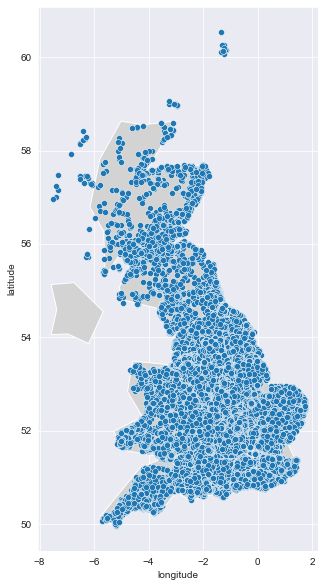

In [55]:
fig, ax1 = plt.subplots(figsize=(14,10))

df_UK.plot( color = 'lightgrey',ax = ax1)
sns.scatterplot( x='longitude', 
                 y= 'latitude', 
                 data = df_accidents_V3,
                 ax = ax1)

# Thoughts 

From the graph above, we can see accidents are occuring throughout UK, however, it is hard to determine any clusters due to the large dot size.

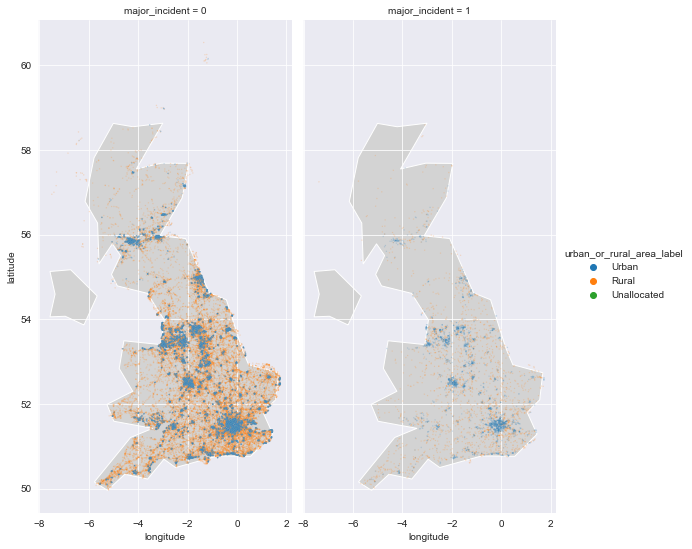

In [43]:


g = sns.relplot(x='longitude', 
            y= 'latitude', 
            data = df_accidents_V3,
            col = 'major_incident',
            hue = 'urban_or_rural_area_label',
            kind = 'scatter',
            alpha = 0.2,
            s =  2,
            height = 8,
            aspect = 0.5)


for ax in g.axes[0]:
    df_UK.plot( color = 'lightgrey', ax = ax , zorder = 0 )



# Thoughts
From the graph above, there are two clusters of interest where accidents are occuring, more specifically at (0, 51.5) and (-2,53)

(51.0, 52.0)

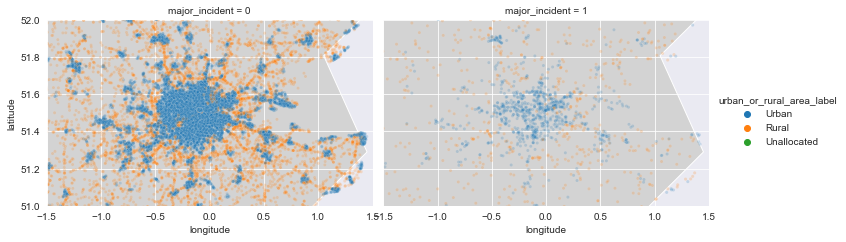

In [44]:
g = sns.relplot(x='longitude', 
            y= 'latitude', 
            data = df_accidents_V3,
            col = 'major_incident',
            hue = 'urban_or_rural_area_label',
            kind = 'scatter',
            alpha = 0.2,
            s =  10)


for ax in g.axes[0]:
    df_UK.plot( color = 'lightgrey', ax = ax , zorder = 0 )

#plt.subplots_adjust(wspace = .2)
plt.xlim([-1.5,1.5])
plt.ylim([51,52])

# Thoughts

From the graph above, I take a closer look at one of the clusters with high quantities of accidents. This location is London, UK. London contains majority of the major accidents in the UK.

(52.0, 54.0)

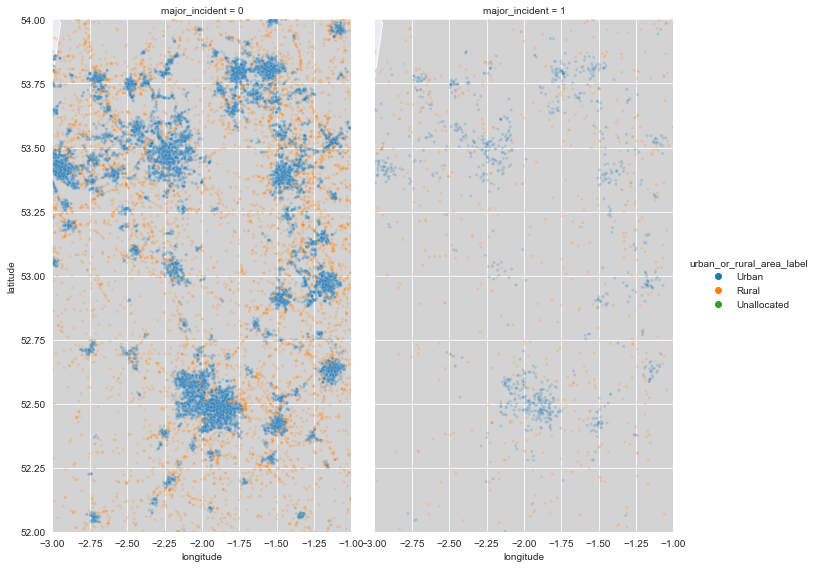

In [45]:
g = sns.relplot(x='longitude', 
            y= 'latitude', 
            data = df_accidents_V3,
            col = 'major_incident',
            hue = 'urban_or_rural_area_label',
            kind = 'scatter',
            alpha = 0.2,
            s =  10,
            height = 8,
            aspect = 0.6)

for ax in g.axes[0]:
    df_UK.plot( color = 'lightgrey', ax = ax , zorder = 0 )

# plt.subplots_adjust(wspace = .2)
plt.xlim([-3,-1])
plt.ylim([52,54])

# Thoughts

From the graph above, I take a closer look at the second cluster of accidents. This cluster contained mini clusters that are different cities in the UK. More specifically, Birmingham, Manchester, Liverpol, Sheffield, Nottingham, and Leicester.

# Thoughts

So far, it has been seen that majority of accidents come from Urban Areas with rural accidents happening around the Urban area. Next, I'll perform a K-mean to cluster the accidents based on characteristics in major_incident, accident severity , first_road_class , road_type , speed_limit,  second_road_class, light_condition , weather_condition, and road_surface_condition.

In [83]:
df_accidents_V3_major_only_noNA = df_accidents_V3[df_accidents_V3['major_incident'] == 1].dropna().copy(deep = True)
df_accidents_V3_major_only_noNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4681 entries, 11 to 91183
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date_time                   4681 non-null   datetime64[ns]
 1   accident_index              4681 non-null   object        
 2   accident_year               4681 non-null   int64         
 3   accident_reference          4681 non-null   object        
 4   longitude                   4681 non-null   float64       
 5   latitude                    4681 non-null   float64       
 6   accident_severity           4681 non-null   int64         
 7   number_of_vehicles          4681 non-null   int64         
 8   number_of_casualties        4681 non-null   int64         
 9   day_of_week                 4681 non-null   int64         
 10  first_road_class            4681 non-null   int64         
 11  first_road_number           4681 non-null   int64     

In [150]:
cols_interest = ['major_incident', 'accident_severity' , 'first_road_class' , 'road_type' , 'speed_limit',  
                'second_road_class', 'light_conditions' , 'weather_conditions', 'road_surface_conditions','number_of_casualties','junction_detail']

x = df_accidents_V3_major_only_noNA.loc[:,cols_interest]
y = df_accidents_V3_major_only_noNA.loc[:,'accident_index']

KNN_classifier = KNN(n_clusters=5)

KNN_classifier.fit(x,y)

df_accidents_V3_major_only_noNA['cluster'] = KNN_classifier.labels_



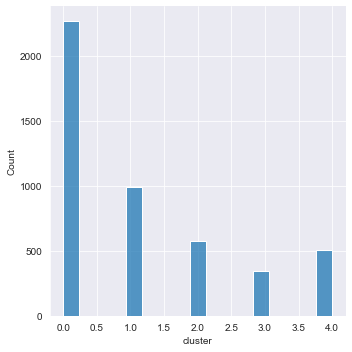

In [151]:
sns.displot(x = 'cluster',
            data = df_accidents_V3_major_only_noNA,
            kind = 'hist' )

(50.0, 54.0)

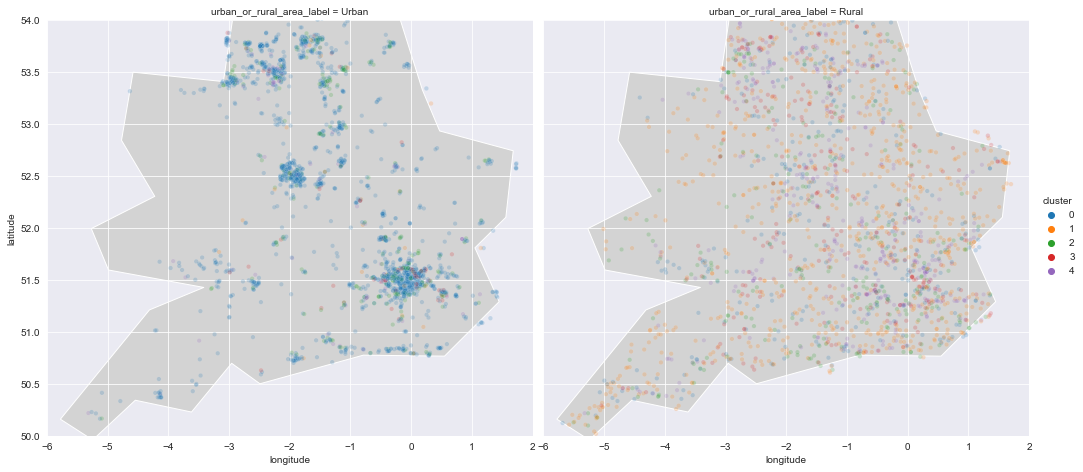

In [153]:
g = sns.relplot(x='longitude', 
            y= 'latitude', 
            data = df_accidents_V3_major_only_noNA,
            hue = 'cluster',
            kind = 'scatter',
            col = 'urban_or_rural_area_label',
            palette = sns.color_palette()[:5],
            alpha = 0.2,
            s =  20,
            height = 8,
            aspect = 0.9)


for ax in g.axes[0]:
    df_UK.plot( color = 'lightgrey', ax = ax , zorder = 0 )

plt.xlim([-6,2])
plt.ylim([50,54])



After clustering the data together, we saw that majority of the major accidents fit into two clusters. On one cluster, majority of accidents are found in an urban area. In contrast, the second cluster has mostly rural accidents. 

In [154]:
clust_idx = df_accidents_V3_major_only_noNA['cluster'].value_counts().index[:2]

df_clust1 = df_accidents_V3_major_only_noNA[ df_accidents_V3_major_only_noNA['cluster'] == clust_idx[0] ]
df_clust2 = df_accidents_V3_major_only_noNA[ df_accidents_V3_major_only_noNA['cluster'] == clust_idx[1] ]

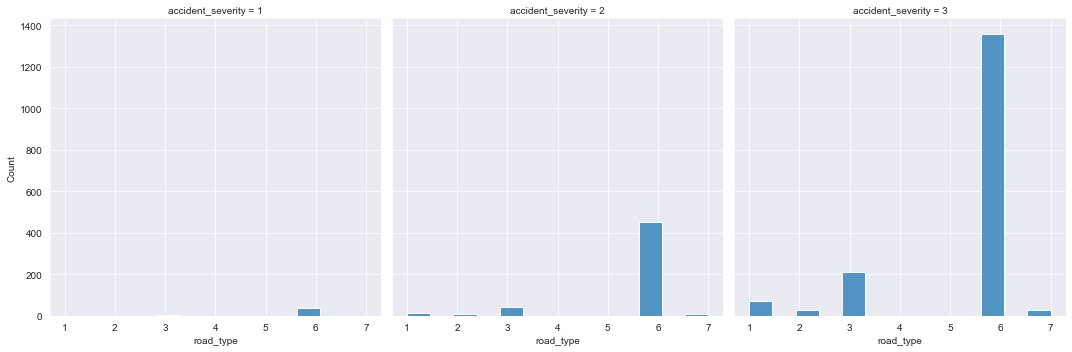

In [155]:
sns.displot(x = 'road_type',
         data = df_clust1[cols_interest],
         col = 'accident_severity',
         kind = 'hist')

accident_severity
* 1	Fatal
* 2	Serious
* 3	Slight

road_type

* 1:	Roundabout
* 2:	One way street
* 3:	Dual carriageway
* 6:	Single carriageway
* 7:	Slip road
* 9:	Unknown
* 12:	One way street/Slip road


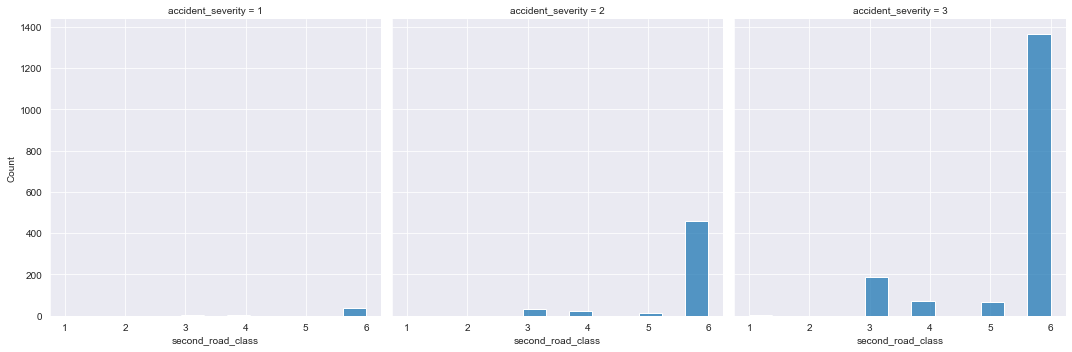

In [156]:
sns.displot(x = 'second_road_class',
         data = df_clust1[cols_interest],
         col = 'accident_severity',
         kind = 'hist')

Second Road Class
* 0	Not at junction or within 20 metres
* 1	Motorway
* 2	A(M)
* 3	A
* 4	B
* 5	C
* 6	Unclassified

accident_severity
* 1	Fatal
* 2	Serious
* 3	Slight


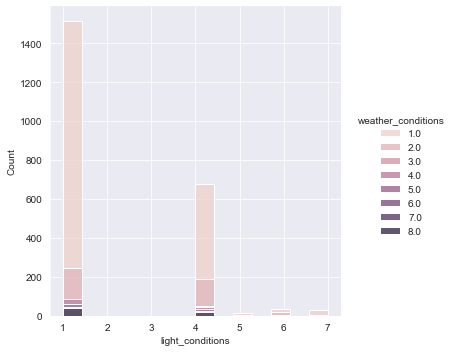

In [157]:
sns.displot(x = 'light_conditions',
         data = df_clust1[cols_interest],
         hue = 'weather_conditions',
         kind = 'hist',
         multiple="stack")

Light Condition

* 1	Daylight
* 4	Darkness - lights lit
* 5	Darkness - lights unlit
* 6	Darkness - no lighting
* 7	Darkness - lighting unknown

Weather Condition 

* 1	Fine no high winds
* 2	Raining no high winds
* 3	Snowing no high winds
* 4	Fine + high winds
* 5	Raining + high winds
* 6	Snowing + high winds
* 7	Fog or mist
* 8	Other


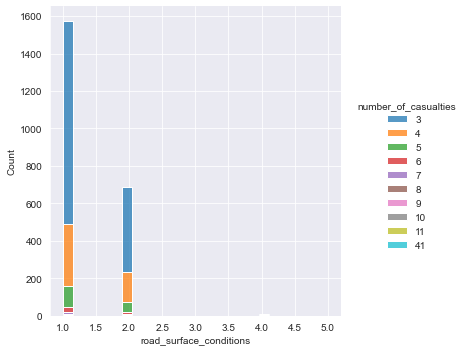

In [158]:
sns.displot(x = 'road_surface_conditions',
         data = df_clust1[cols_interest],
         hue = 'number_of_casualties',
         palette = sns.color_palette(),
         kind = 'hist',
         multiple="stack")

Road Surface Conditions

* 1	Dry
* 2	Wet or damp
* 3	Snow
* 4	Frost or ice
* 5	Flood over 3cm. deep
* 6	Oil or diesel
* 7	Mud


In [164]:
df_clust1[cols_interest]['junction_detail'].value_counts().sort_index()

0.0    716
1.0    120
2.0     46
3.0    752
5.0     23
6.0    400
7.0     49
8.0     41
9.0    120
Name: junction_detail, dtype: int64

Junction Detail
* 0	Not at junction or within 20 metres
* 1	Roundabout
* 2	Mini-roundabout
* 3	T or staggered junction
* 5	Slip road
* 6	Crossroads
* 7	More than 4 arms (not roundabout)
* 8	Private drive or entrance
* 9	Other junction


In [165]:
df_clust1[cols_interest]['speed_limit'].value_counts().sort_index()

20.0     206
30.0    2061
Name: speed_limit, dtype: int64